# Cheat Sheet -  Logistic Regression

Logistic regression is another classifier, and perhaps the most commonly used one. It is a bit different from our Naive Bayes and Classification trees in that it is not only explainable, but also has the potential for providing causal inference. Now, it doesn't *actually* speak to causality, but as you will see, the results provide a feature by feature breakdown on the impact of causing an event (just like a regular regression's coefficients speak to the impact on a continuous value!). 

It uses a different underlying distribution than we're used to seeing, has an s-shaped curve output, and the default model is only good for predicting binary outcomes (though multinomial logistic regressions are available). 

## Instructions

**1.	Start a new project and import the loan acceptance data**

I know, I know - I like the iris data too. But let's start with a binary classifier. 

In [9]:
#Import pandas, and then the data

import pandas as pd
bank_df = pd.read_csv('UniversalBank.csv')

**2. Run some summary statistics**

As always - running $\text{dtypes}$ and $\text{describe()}$ is a good way to get a summary of your dataset.

In [10]:
bank_df.dtypes

ID                      int64
Age                     int64
Experience              int64
Income                  int64
ZIP Code                int64
Family                  int64
CCAvg                 float64
Education               int64
Mortgage                int64
Personal Loan           int64
Securities Account      int64
CD Account              int64
Online                  int64
CreditCard              int64
dtype: object

In [11]:
bank_df.describe()

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000
mean,2500.500000,45.338400,20.104600,73.774200,93152.503000,2.396400,1.937938,1.881000,56.498800,0.096000,0.104400,0.06040,0.596800,0.294000
std,1443.520003,11.463166,11.467954,46.033729,2121.852197,1.147663,1.747659,0.839869,101.713802,0.294621,0.305809,0.23825,0.490589,0.455637
min,1.000000,23.000000,-3.000000,8.000000,9307.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,1250.750000,35.000000,10.000000,39.000000,91911.000000,1.000000,0.700000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,2500.500000,45.000000,20.000000,64.000000,93437.000000,2.000000,1.500000,2.000000,0.000000,0.000000,0.000000,0.00000,1.000000,0.000000
75%,3750.250000,55.000000,30.000000,98.000000,94608.000000,3.000000,2.500000,3.000000,101.000000,0.000000,0.000000,0.00000,1.000000,1.000000
max,5000.000000,67.000000,43.000000,224.000000,96651.000000,4.000000,10.000000,3.000000,635.000000,1.000000,1.000000,1.00000,1.000000,1.000000


You can actually observe a fair bit from this output - including some possible targets! Observe a few of the columns and thein min/max combos - if they are 0/1 respectively, there's a good chance it's a binary and a potential target. Also, the mean is the % of records in class '1'! 

In [12]:
bank_df['Personal Loan'].unique()

array([0, 1])

**3. This data needs to be cleaned** *(this is a good practice for all datasets, so only skip it if you're using iris!)

In [13]:
#We don't need ID or ZIP code for this analysis, so let's drop them
bank_df.drop(columns=['ID', 'ZIP Code'], inplace=True)
#We also really don't like spaces in our variable name, so let's replace those with underscores. 
bank_df.columns = [c.replace(' ', '_') for c in bank_df.columns]
#Education is also categorical - it would be bad to leave it as a numeric, so let's turn it into dummy variables
#First, make it categorical
bank_df['Education'] = bank_df['Education'].astype('category')
#define our new categories
new_categories = {1: 'Undergrad', 2: 'Graduate', 3: 'Advanced/Professional'}
#Rename the categories with what the above
bank_df.Education.cat.rename_categories(new_categories, inplace=True)
#use get_dummies to turn them into dummies. Remember that we can only include n-1 dummy variables, so need to drop one
bank_df = pd.get_dummies(bank_df, prefix_sep='_', drop_first=True)

**4. Split the data into train and test sets**

In [14]:
from sklearn.model_selection import train_test_split
y=bank_df['Personal_Loan']
X=bank_df.drop(columns=['Personal_Loan'])
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=0)

**5. Look at the Logistic Regression help file from sci-kit learn and train your model**

To create our model, we will use the sci-kit learn library. Referencing the following documentation, we can train our model.

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

There are a few important arguments for logistic regression
1. penalty - l2 is the default and behaves like a ridge regression. Set l1 for LASSO or elasticnet
2. C - set to 1 by default, set to 1e42 for (nearly) no regularization 
3. solver - set to lbfgs by default. Use liblinear for binary classification on small datasets. sag or saga otherwise
4. multi_class - set to multinomial for a multiclass prediction problem

We're going to use an l2 penalty, 1e42 and liblinear.

In [19]:
from sklearn.linear_model import LogisticRegression

logit_reg = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
logit_reg.fit(X_train, y_train)

LogisticRegression(C=1e+42, solver='liblinear')

**6. Evaluate the model**

A logistic regression behaves more like a linear regression in that it produces coefficients for each variable. We'll print those below and add the AIC to better understand model performance.

In [20]:
#Print the results and some evaluation criteria
from dmba.metric import AIC_score
print('intercept ', logit_reg.intercept_[0])
print(pd.DataFrame({'coeff': logit_reg.coef_[0]}, index=X.columns).transpose())
print('AIC', AIC_score(y_test, logit_reg.predict(X_test), df = len(X_train.columns)
+ 1))

intercept  -11.700147044546592
            Age  Experience    Income    Family     CCAvg  Mortgage  \
coeff -0.073991    0.079098  0.060857  0.551365  0.247074  0.001053   

       Securities_Account  CD_Account    Online  CreditCard  \
coeff           -0.798477    3.880795 -0.901423   -1.008795   

       Education_Graduate  Education_Advanced/Professional  
coeff            4.468687                         4.461307  
AIC -518.7041847614673


Alright - AIC looks great (as usual!). A few things worth calling out here:

1. C is a hyperparameter associated with the penalty. Just like in Ridge and LASSO, it is basically your feature selection penalty and can be tuned
2. You can't interpret logistic regression coefficients the same way you would linear regression. 

**Interpreting the coefficients**
Remember that our logistic regression coefficients are actually in the log of odds - we need to do this because log of odds has an infinite range (where probability is constrained between 0 and 1, making it hard to measure. 

Let's go through an example from above. 

1. The coefficient for CreditCard is -1.007555. This means that we expect a customer with a credit cards to have a log of odds 1.007555 *lower* than one without a credit card
2. We can exponentiate that value to get an odds value of 0.36
3. In principle, we can turn that into a probability, but this doesn't make sense until we're looking at any entire observation - the equation is $\frac{Odds}{1+Odds}$

So, really, all we can take away from these coefficients is the direction. To understand magnitude, you really need to move into odds. 

In [17]:
from dmba import classificationSummary

classificationSummary(y_train, logit_reg.predict(X_train))
classificationSummary(y_test, logit_reg.predict(X_test))

Confusion Matrix (Accuracy 0.9597)

       Prediction
Actual    0    1
     0 3111   37
     1  104  248
Confusion Matrix (Accuracy 0.9593)

       Prediction
Actual    0    1
     0 1353   19
     1   42   86


Interpret these the way we always do - everything looks pretty good here and we're obviously not overfitting. Spend some time and consider what each cell in the confusion matrix means from a business perspective here! 

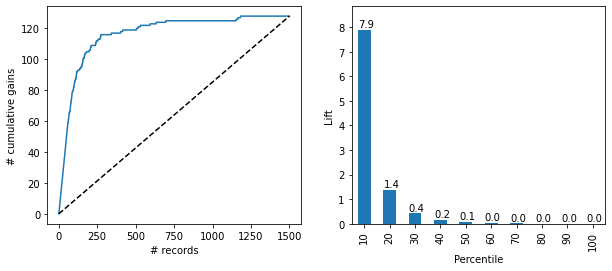

In [18]:
%matplotlib inline
import matplotlib.pylab as plt
from dmba import gainsChart, liftChart

logit_reg_pred = logit_reg.predict(X_test)
logit_reg_proba = logit_reg.predict_proba(X_test)
logit_result = pd.DataFrame({'actual': y_test,
'p(0)': [p[0] for p in logit_reg_proba],
'p(1)': [p[1] for p in logit_reg_proba],
'predicted': logit_reg_pred })


df = logit_result.sort_values(by=['p(1)'], ascending=False)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
gainsChart(df.actual, ax=axes[0])
liftChart(df['p(1)'], title=False, ax=axes[1])
plt.show()

Here are two new important plots. You will see (and produce) these frequently. 

**Gains Chart**

The gains chart shows the number of positive responses (in this case, accepting a loan) given a certain number of customers contact (# of records on the chart above). The dashed line down the middle represents random chance, and the solid blue line is how our model performs. The bigger the gap between these lines, the higher the performance!

**Lift Chart**

The decile lift chart also tells us how much better our model performs than random. In this case, it is saying if we took 10% of the data based on our model, we would expect to find 7.9 times the number of successes than at random. Obviously, we expect this to go to 0 when we hit 100% 